In [1]:
from lab_control import Measurement
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
plt.style.use("https://lkies.net/vscdark")

The DFT $|X_k|^2$ and the discrete approximation of the power spectral density $S_k$ are proportional to each other but not equal. The proportionality can be derived from power / energy conservation.

The power in the time domain is computed as follows:

$$P = \frac{1}{T} \int_{0}^{T} x(t)^2 dt$$

or in discrete form:

$$P = \frac{1}{T} \sum_{n=0}^{N-1} x_n^2 \Delta t$$

where $\Delta t = T/N$ is the time step.

While the power in frequency domain is computed from the power spectral density $S(f)$ as follows:

$$P = \int_{0}^{\infty} S(f) df$$

where S has units $\mathrm{W}/\mathrm{Hz}$

or similarly in discrete form:

$$P = \sum_{k=0}^{N-1} S_k \Delta f$$

where $\Delta f = 1/T = 1/(N \Delta t)$ is the frequency step.

The "ortho" ($1/\sqrt{N}$) normalized DFT conserves the norm of the time series.

$$\sum_{n=0}^{N-1} x_n^2 = \sum_{k=0}^{N-1} |X_k|^2$$

we can substitute it to the discrete time power formula and set it equal to the power in the frequency domain:

$$
\begin{align*}
P_\mathrm{time} &= P_\mathrm{freq} \\
\frac{1}{T} \sum_{n=0}^{N-1} x_n^2 \Delta t &= \sum_{k=0}^{N-1} S_k \Delta f \\
\frac{1}{T} \sum_{k=0}^{N-1} |X_k|^2 \Delta t &= \sum_{k=0}^{N-1} S_k \frac{1}{T} \\
|X_k|^2 \Delta t &= S_k \\
\end{align*}
$$

We could cancel out the sum since $|X_k|^2$ and $S_k$ are proportional to each other by definition. The proportionality factor is $\Delta t = T/N$.

The expectation value is computed across the power density spectra not the amplitude spectral density. This also follows from power / energy conservation.

$$S(f) = A(f)^2 = E[\hat{S}(f)]$$

In [2]:
def power_spectral_density(dfs: list[pd.DataFrame], channel, scale=1):
    delta_t = dfs[0].index[1] - dfs[0].index[0]
    def spec(df):
        data = df[channel]
        data -= data.mean()
        return np.abs(np.fft.fft(data, norm="ortho"))**2 * delta_t
    spectra = [spec(df)*scale**2 for df in dfs]
    median = np.median(spectra, axis=0)
    mean = np.mean(spectra, axis=0)
    N = len(mean)
    assert N % 2 == 0
    # remove the power from the negative frequencies and add it to the positive ones
    ones_and_zeroes = np.concatenate([np.ones(N//2), np.zeros(N//2)])
    weights = ones_and_zeroes + np.roll(ones_and_zeroes, 1)
    mean *= weights
    median *= weights
    freqs = np.abs(np.fft.fftfreq(len(dfs[0]), d=delta_t))
    res = pd.DataFrame({"freq": freqs, "mean": mean, "median": median}).iloc[1:N//2+1].set_index("freq")
    return res

## Process Noise

First determine the sensitivity of the piezo.

<Axes: xlabel='time_s'>

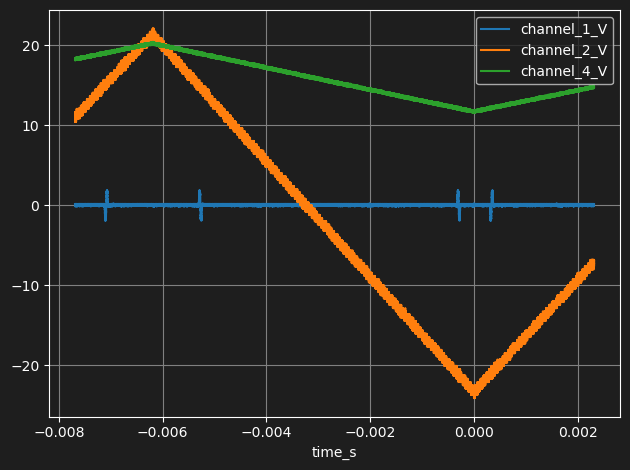

In [3]:
piezo_ref = Measurement.load("piezo_ref.csv")
piezo_ref.df.plot()

In [4]:
OSC_PROBE_RATIO = 10
HV_PROBE_RATIO = 100

piezo_ref_data = piezo_ref.df.iloc[110000:380000,[0, 2]]

slope = np.abs(np.polynomial.Polynomial.fit(piezo_ref_data.index, piezo_ref_data.iloc[:, 1], 1).convert().coef[1])

# messy peak detection
piezo_ref_data["channel_1_V"] = piezo_ref_data["channel_1_V"].rolling(window=1001, center=True).mean()
grad = np.gradient(piezo_ref_data["channel_1_V"])
peak_points = np.argwhere(grad < -0.0033).flatten()
spaces = np.diff(peak_points, prepend=peak_points[0])
seperators = np.argwhere(spaces > 1000).flatten()
segments = np.split(peak_points, seperators)
peak_centers = [np.mean(piezo_ref_data["channel_4_V"].values[segment]) for segment in segments]
fsr_voltage_diff = np.abs(np.diff(peak_centers))[0] / OSC_PROBE_RATIO

fsr_length_diff = 1064e-9
channel_4_V_to_m = fsr_length_diff / fsr_voltage_diff
print(f"{channel_4_V_to_m = }")
print(f"pieze_V_to_m = {channel_4_V_to_m / HV_PROBE_RATIO}")

channel_4_V_to_m = 1.5537688824496244e-06
pieze_V_to_m = 1.5537688824496242e-08


Now calculate the noise. Assume that (at least for low frequencies) the piezo follows the noise.

In [5]:
files = list(Path('piezo_and_error_noise').glob('*.csv'))
dfs_piezo = [Measurement.load(f).df for f in files]

In [6]:
spectrum_piezo_df = power_spectral_density(dfs_piezo, "channel_4_V", channel_4_V_to_m / OSC_PROBE_RATIO) # cancel out the probe ratio again
freqs, spectrum, median = spectrum_piezo_df.index.values, spectrum_piezo_df["mean"].values, spectrum_piezo_df["median"].values

Make a 1/f fit to the noise.

In [7]:
def log_one_over_f_sq(f, A0):
    return 2*np.log(A0) - 2*np.log(f)

spectrum_valid = spectrum_piezo_df.query("freq > 1e-1 and freq < 1e1")
(A0, ), _ = curve_fit(log_one_over_f_sq, spectrum_valid.index, np.log(spectrum_valid["mean"]), p0=[1e-10])
print(f"A(1 Hz) = {A0} m/sqrt(Hz)")

A(1 Hz) = 9.259560617869448e-11 m/sqrt(Hz)


Determine quantization step size for quantization noise.

In [8]:
Vs = dfs_piezo[0]["channel_4_V"].iloc[:200]
delta_Vs = np.abs(np.diff(Vs))
delta_V = delta_Vs[delta_Vs > 0].min()
delta_l = delta_V * channel_4_V_to_m / OSC_PROBE_RATIO
delta_l

2.498522812057926e-10

Plot everything together.

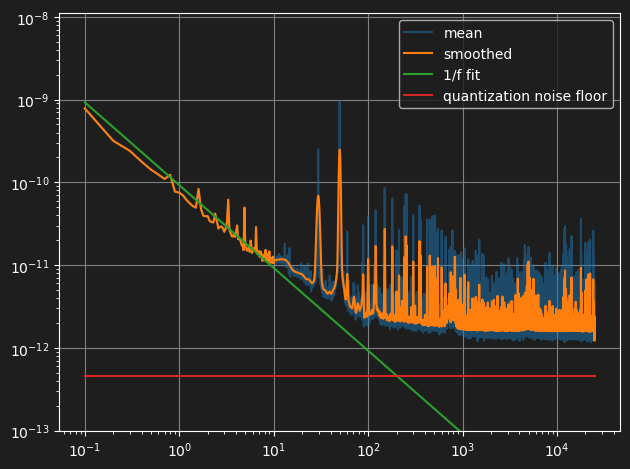

In [9]:
kernel = np.exp(-np.linspace(-5, 5, 100)**2)
kernel /= kernel.sum()

plt.loglog(freqs, np.sqrt(spectrum), label="mean", alpha=0.5)
smoothed = spectrum.copy()
smoothed[100:] = np.convolve(spectrum, kernel, mode="same")[100:]
plt.plot(freqs, np.sqrt(smoothed), label="smoothed")
plt.plot(freqs, A0/freqs, label="1/f fit")
plt.ylim(1e-13, 11e-9)
quant_noise_floor = delta_l/(2*np.sqrt(3))/np.sqrt(np.max(freqs))
plt.plot(freqs[[0, -1]], [quant_noise_floor, quant_noise_floor], label="quantization noise floor")
plt.legend()

For high frequencies the noise is dominated by quantization noise or other sources, it is reasonable to assume that the true cavity noise continues as 1/f noise.

## Measurement Noise

The measured data is from the locked cavity. For high frequencies the control loop cannot keep up with the process, however the process noise is very small at hight frequencies so it is reasonable to assume. That the measured noise at high frequencies is dominated by the measurement noise.

First get the span between minimum and maximum reflection.

In [10]:
ref_noise_ref = Measurement.load("reflection_ref.csv")

0.4246227200000003 17.54872970199987


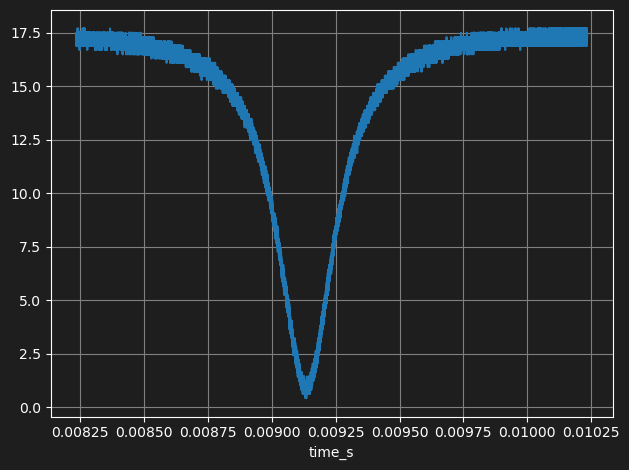

In [11]:
ref_noise_ref.df.iloc[200000:-200000]["channel_4_V"].plot()
V_max = np.mean([np.mean(ref_noise_ref.df.iloc[:200000]["channel_4_V"]), np.mean(ref_noise_ref.df.iloc[-200000:]["channel_4_V"])])
V_max
V_min = np.min(ref_noise_ref.df["channel_4_V"])
print(V_min, V_max)

In [12]:
dfs_reflection = [Measurement.load(f).df for f in Path('reflection_noise').glob('*.csv')]

In [13]:
psd_ref = power_spectral_density(dfs_reflection, "channel_4_V", 1/OSC_PROBE_RATIO)

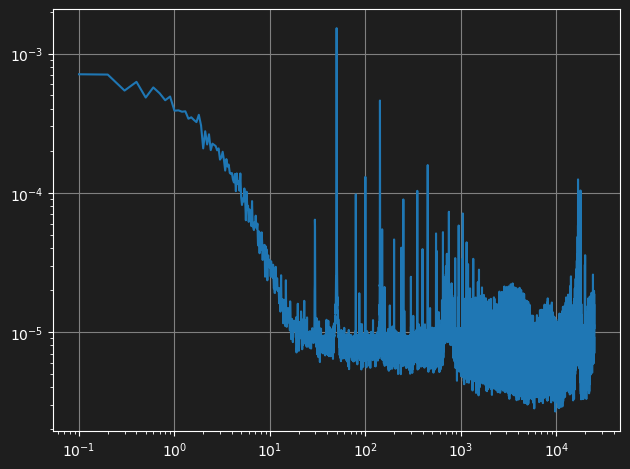

In [14]:
plt.loglog(psd_ref.index, np.sqrt(psd_ref["mean"]), label="mean")

In [15]:
# assume the measurement noise is white, take the mean where it is valid, then integrate across the whole spectrum
measurement_noise = np.sqrt(np.mean(psd_ref.query("freq > 1e2")["mean"].mean()) * psd_ref.index[-1])
print(f"{measurement_noise = }")

measurement_noise = 0.0012676627053306597
